## Loading main libraries and packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Loading data

In [2]:
!ls inputs/

test.csv
test3.csv
train.csv


In [3]:
train_df = pd.read_csv("inputs/train.csv")
test_df = pd.read_csv("inputs/test.csv")
combine = [train_df, test_df]

In [4]:
train_df.shape, test_df.shape

((15120, 56), (565892, 55))

## Undestanding dataset shape and data main characteristics

In [5]:
# Find what are the differences in features, likely the predicted variable to test
set(train_df.columns) - set(test_df.columns)

{'Cover_Type'}

In [6]:
train_df.columns

Index(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_

In [7]:
train_df["Cover_Type"].value_counts()

5    2160
2    2160
1    2160
7    2160
3    2160
6    2160
4    2160
Name: Cover_Type, dtype: int64

- Id can be discarded from both datasets (only useful to identify the results later) 

- Cover_Type is the predicted variable we wish to estimate
- Cover_Type is a caragorical variable wil 7 possible outcomes [1,2,3,4,5,6,7], which makes our problem a multiclass classification problem
- Train data seem equally distributed around Cover_types, wihch is a good sign, but train data is much smaller than test ones properly

- Elevation, Aspect, Slope, Distances seem to be data relative to distance and degrees, therefore real, continuous values
- Hillshade seems to be a range from 1 to 255, therefore integer values
- Soil Types, Wilderness_Area seem to be dummy binary variables, that are quite sparse

We can create "Wilderness_Area" and "Soil_Type" variables so we can reduce data sparsity for models that handle this better (e.g., Decision Trees and RandomForest)

Other models benefit from linearity (e.g., Multiclass Logistic Regression, SVMs, etc)

In [8]:
for i in range(1,5):
    print(train_df[f"Wilderness_Area{i}"].value_counts())

0    11523
1     3597
Name: Wilderness_Area1, dtype: int64
0    14621
1      499
Name: Wilderness_Area2, dtype: int64
0    8771
1    6349
Name: Wilderness_Area3, dtype: int64
0    10445
1     4675
Name: Wilderness_Area4, dtype: int64


In [9]:
# Total de linhas bate com o total de WIlderness_Area = 1, o que indica que são variáveis MECE
train_df.loc[:,train_df.columns.str.startswith("Wilderness_Area")].sum().sum()

15120

In [10]:
train_df.loc[:,train_df.columns.str.startswith("Soil_Type")].sum().sum()

15120

In [11]:
# Soil types, seem to follow a MECE structure, with only one soil type per instance

## EDA and Feature Engineering - trying to understand and treat variables to predict our classes

### Let's see if there are nulls to be handled

It seems there are no direct null values to be treated, maybe as zeros....

In [12]:
train_df.isnull().sum()

Id                                    0
Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area1                      0
Wilderness_Area2                      0
Wilderness_Area3                      0
Wilderness_Area4                      0
Soil_Type1                            0
Soil_Type2                            0
Soil_Type3                            0
Soil_Type4                            0
Soil_Type5                            0
Soil_Type6                            0
Soil_Type7                            0
Soil_Type8                            0
Soil_Type9                            0
Soil_Type10                           0


In [13]:
test_df.isnull().sum()

Id                                    0
Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area1                      0
Wilderness_Area2                      0
Wilderness_Area3                      0
Wilderness_Area4                      0
Soil_Type1                            0
Soil_Type2                            0
Soil_Type3                            0
Soil_Type4                            0
Soil_Type5                            0
Soil_Type6                            0
Soil_Type7                            0
Soil_Type8                            0
Soil_Type9                            0
Soil_Type10                           0


### Let's understand feature shapes from real value variables (non binary)

In [14]:
real_value_columns = []
for column in train_df.columns:
    if not(column.startswith("Soil_Type") or column.startswith("Wilderness_Area") or column == 'Id' or column == 'Cover_Type'):
        real_value_columns.append(column)

real_value_columns

['Elevation',
 'Aspect',
 'Slope',
 'Horizontal_Distance_To_Hydrology',
 'Vertical_Distance_To_Hydrology',
 'Horizontal_Distance_To_Roadways',
 'Hillshade_9am',
 'Hillshade_Noon',
 'Hillshade_3pm',
 'Horizontal_Distance_To_Fire_Points']

In [15]:
palette = sns.color_palette("hls", 7)
palette

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.8169142857142857, 0.33999999999999997),
 (0.4573714285714283, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.6683428571428571),
 (0.33999999999999997, 0.6059428571428571, 0.86),
 (0.5197714285714281, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.7545142857142858)]

<Axes: xlabel='Elevation', ylabel='Count'>

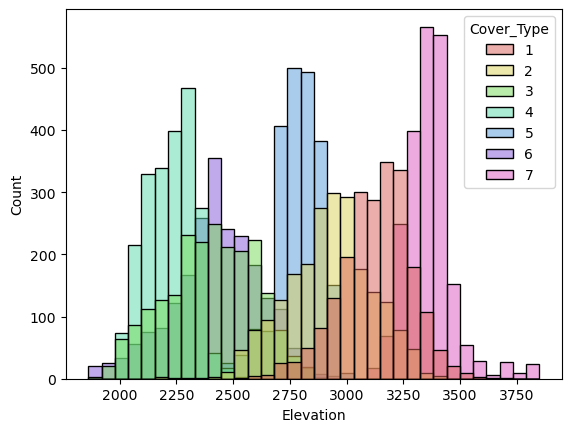

In [16]:
sns.histplot(train_df,x="Elevation", hue="Cover_Type",palette=palette)

<Axes: xlabel='Slope', ylabel='Count'>

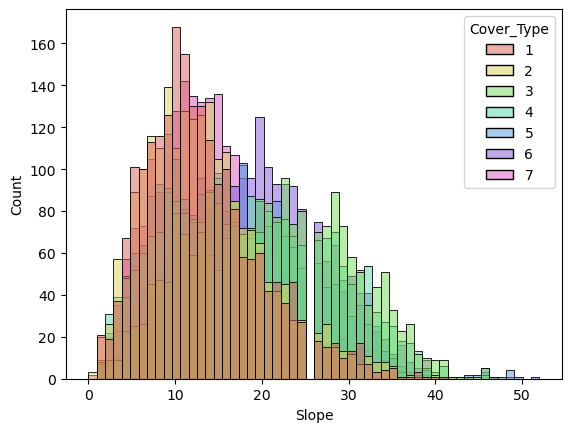

In [17]:
sns.histplot(train_df,x="Slope", hue="Cover_Type",palette=palette)

<Axes: xlabel='Aspect', ylabel='Count'>

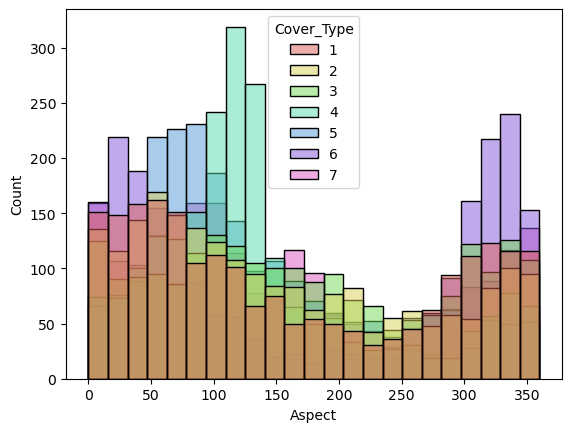

In [18]:
sns.histplot(train_df,x="Aspect", hue="Cover_Type",palette=palette)

<Axes: xlabel='Horizontal_Distance_To_Hydrology', ylabel='Count'>

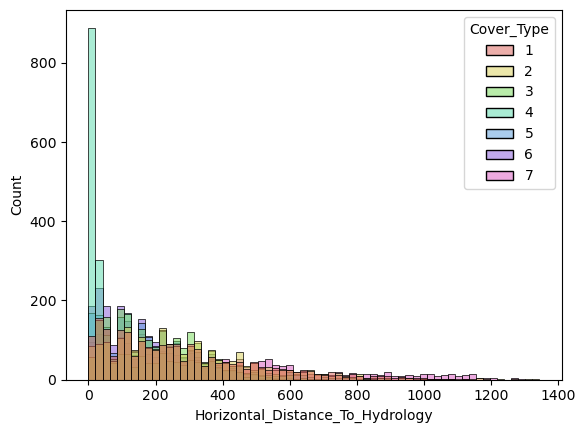

In [19]:
sns.histplot(train_df,x="Horizontal_Distance_To_Hydrology", hue="Cover_Type",palette=palette)

<Axes: xlabel='Vertical_Distance_To_Hydrology', ylabel='Count'>

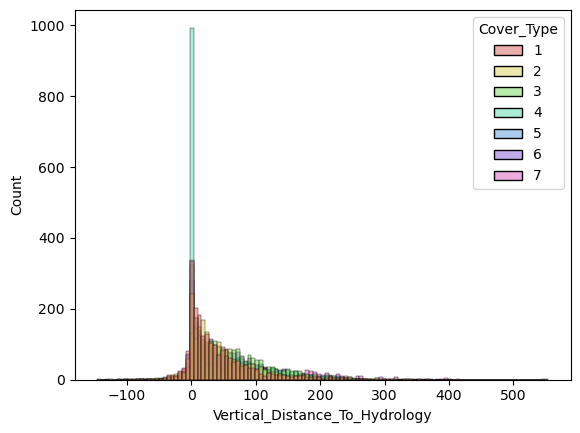

In [20]:
sns.histplot(train_df,x="Vertical_Distance_To_Hydrology", hue="Cover_Type",palette=palette)

<Axes: xlabel='Horizontal_Distance_To_Roadways', ylabel='Count'>

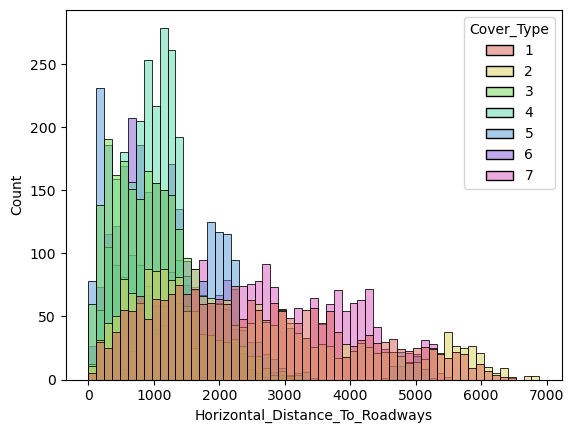

In [21]:
sns.histplot(train_df,x="Horizontal_Distance_To_Roadways", hue="Cover_Type",palette=palette)

<Axes: xlabel='Horizontal_Distance_To_Fire_Points', ylabel='Count'>

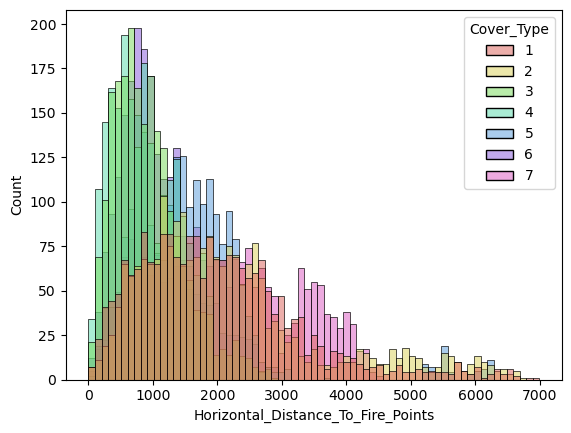

In [22]:
sns.histplot(train_df,x="Horizontal_Distance_To_Fire_Points", hue="Cover_Type",palette=palette)

<Axes: xlabel='Hillshade_Noon', ylabel='Count'>

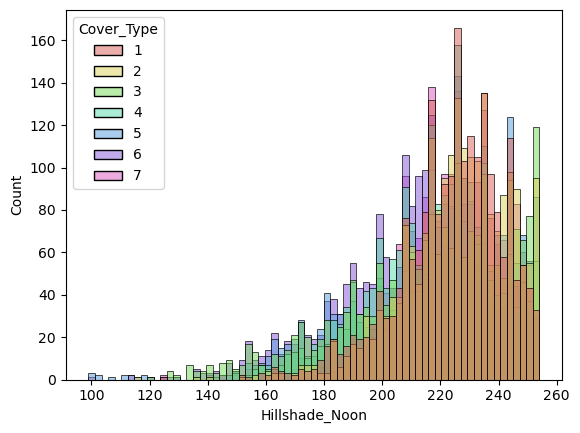

In [23]:
sns.histplot(train_df,x="Hillshade_Noon", hue="Cover_Type",palette=palette)

<Axes: xlabel='Hillshade_9am', ylabel='Count'>

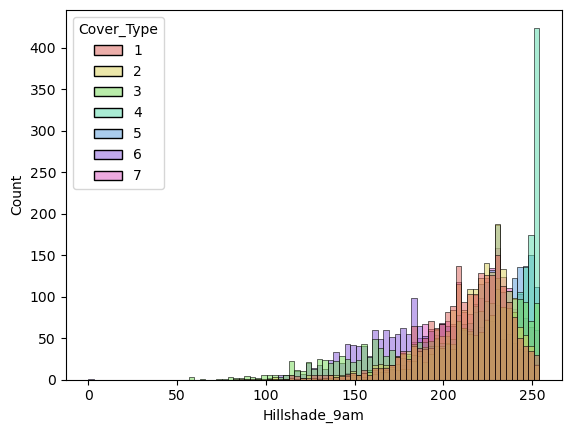

In [24]:
sns.histplot(train_df,x="Hillshade_9am", hue="Cover_Type",palette=palette)

<Axes: xlabel='Hillshade_3pm', ylabel='Count'>

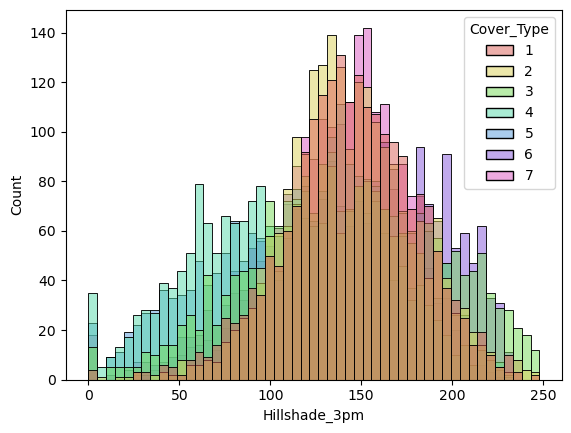

In [25]:
sns.histplot(train_df,x="Hillshade_3pm", hue="Cover_Type",palette=palette)

### Let's also understand correlations

<Axes: >

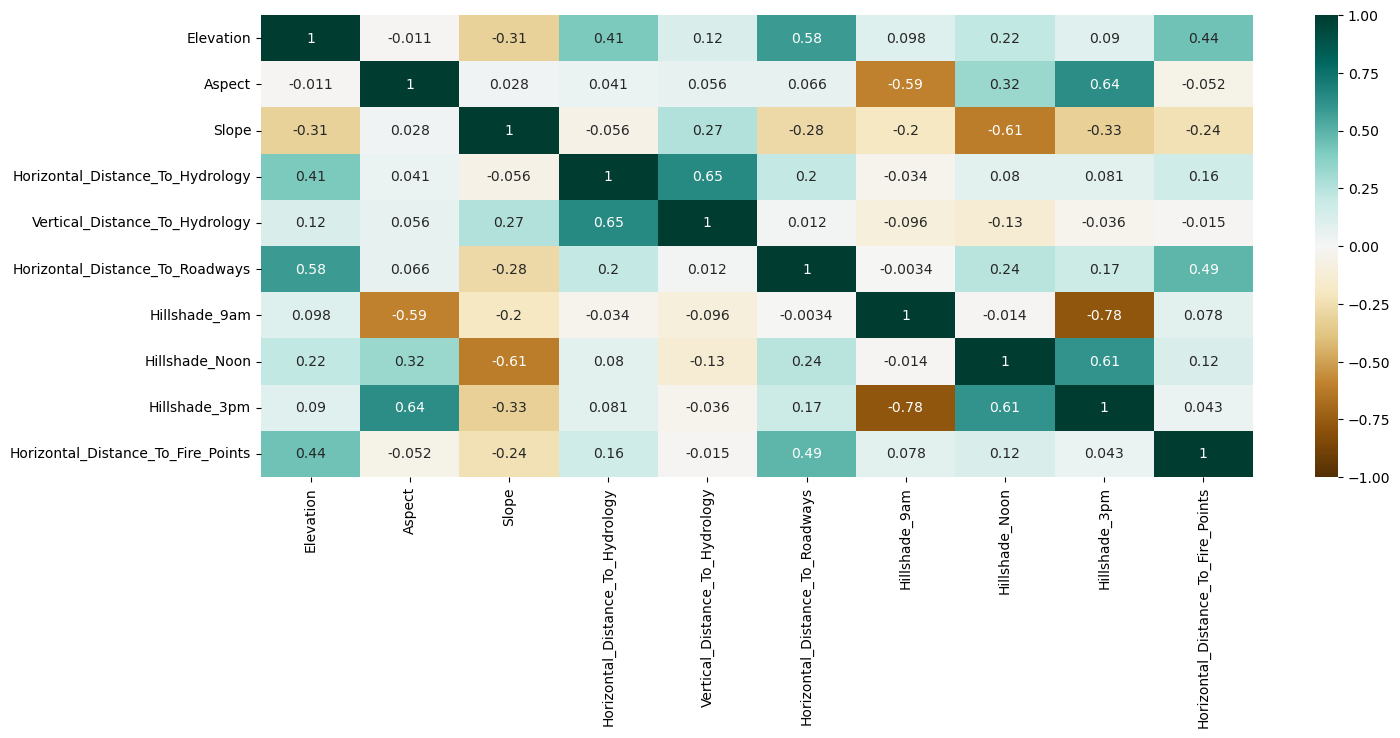

In [26]:
plt.figure(figsize=(16,6))
sns.heatmap(train_df.loc[:,real_value_columns].corr(), vmin=-1.0, vmax=1.0,annot=True,cmap='BrBG')

<Axes: >

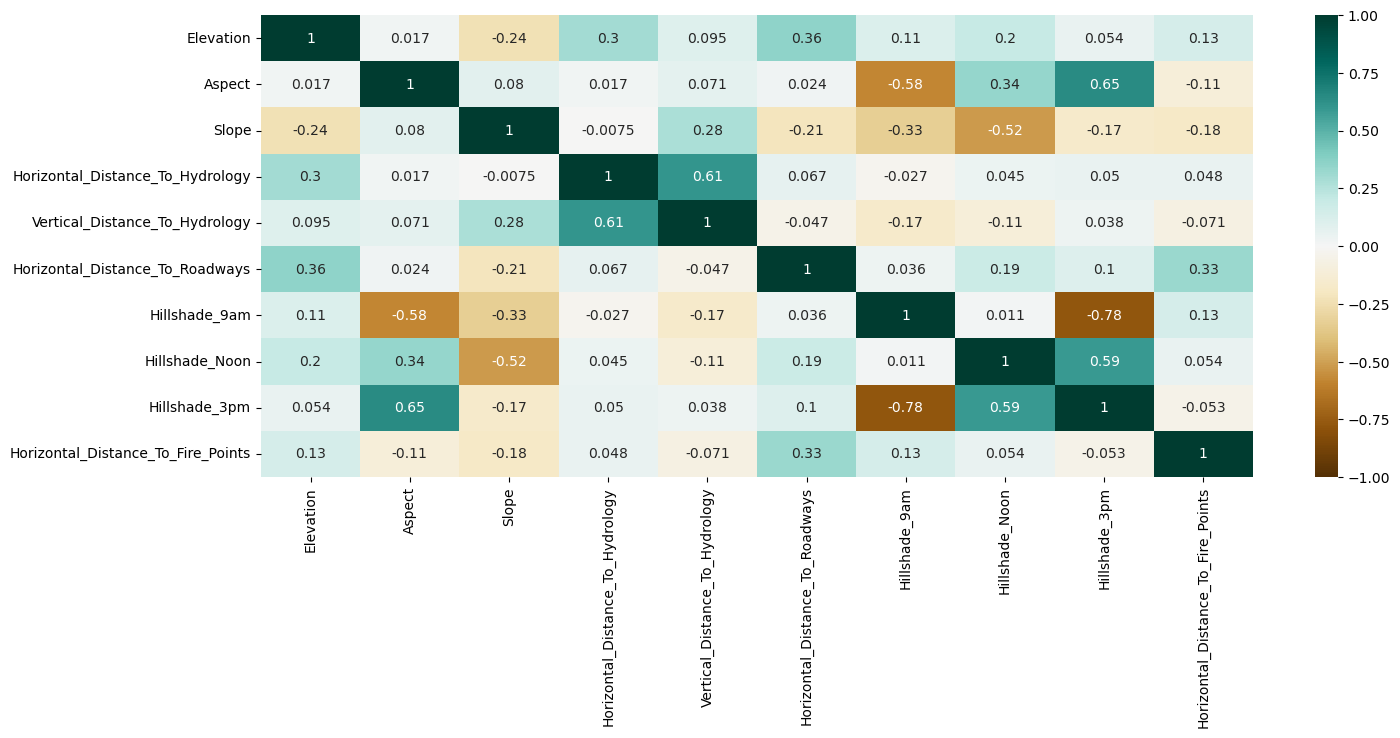

In [27]:
plt.figure(figsize=(16,6))
sns.heatmap(test_df.loc[:,real_value_columns].corr(), vmin=-1.0, vmax=1.0,annot=True,cmap='BrBG')

### Conclusions
- Category 4 from Cover Type seem to grow in wet soil, as it is heavily distributed around distance to hidrology (x,y) ~(0,0)
- Elevation seems to divide well data, but may be a product of Wilderness Area average elevation + Vertical distance to hidrology
  - Sources of water seem important to these problems
  - As most of the data is categorical, odds are that water sources are located in lower elevations in each wilderness Area
  - We probably should separate these effects
- There aren't many strong positive or negative correlations, except from `Hillshade_3pm`, which is highly negatively correlated with `Hillshade_9am` and positively with `Aspect`, therefore it would be interesting to drop it

### Exploring averages by wilderness areas

In [28]:
train_df["Wilderness_Area"] = 0
test_df["Wilderness_Area"] = 0
for df in combine:
    for i in range(1,5):
        df.loc[df[f"Wilderness_Area{i}"] == 1,"Wilderness_Area"] = i

combine = [train_df, test_df]

In [29]:
train_df["Wilderness_Area"].value_counts().sort_values(ascending=False)

3    6349
4    4675
1    3597
2     499
Name: Wilderness_Area, dtype: int64

In [30]:
test_df["Wilderness_Area"].value_counts().sort_values(ascending=False)

1    257199
3    247015
4     32293
2     29385
Name: Wilderness_Area, dtype: int64

In [31]:
train_df["Soil_Type"] = 0
test_df["Soil_Type"] = 0

for df in combine:
    for i in range(1,41):
        df.loc[df[f"Soil_Type{i}"] == 1,"Soil_Type"] = i

combine = [train_df, test_df]

In [32]:
train_df["Soil_Type"].value_counts().sort_values(ascending=False)

10    2142
29    1291
3      962
4      843
23     757
38     728
30     725
32     690
39     657
6      650
2      623
33     616
17     612
13     476
40     459
11     406
1      355
22     345
31     332
24     257
12     227
14     169
5      165
20     139
16     114
35     102
18      60
26      54
19      46
37      34
34      22
21      16
27      15
9       10
36      10
28       9
8        1
25       1
Name: Soil_Type, dtype: int64

In [33]:
test_df["Soil_Type"].value_counts().sort_values(ascending=False)

29    113956
23     56995
32     51829
33     44538
22     33028
10     30492
12     29744
30     29445
31     25334
24     21021
13     16955
38     14845
39     13149
11     12004
4      11553
20      9120
40      8291
2       6902
6       5925
19      3975
3       3861
17      2810
16      2731
1       2676
26      2535
18      1839
35      1789
34      1589
5       1432
9       1137
27      1071
28       937
21       822
25       473
14       430
37       264
8        178
36       109
7        105
15         3
Name: Soil_Type, dtype: int64

<Axes: xlabel='Wilderness_Area', ylabel='Soil_Type'>

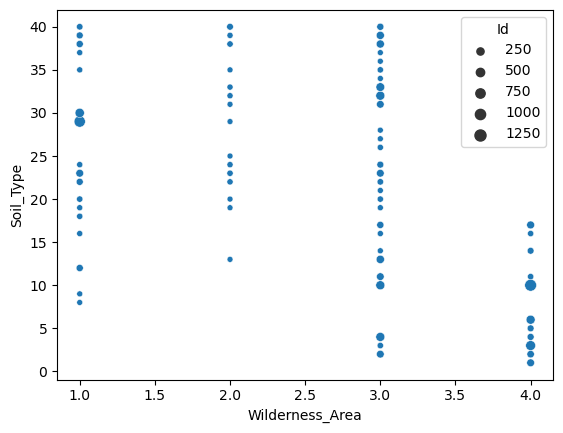

In [34]:
soil_freq_by_area = train_df.groupby(["Wilderness_Area","Soil_Type"], as_index=False)["Id"].count()
sns.scatterplot(soil_freq_by_area, x="Wilderness_Area", y="Soil_Type", size="Id")

<Axes: xlabel='Elevation', ylabel='Count'>

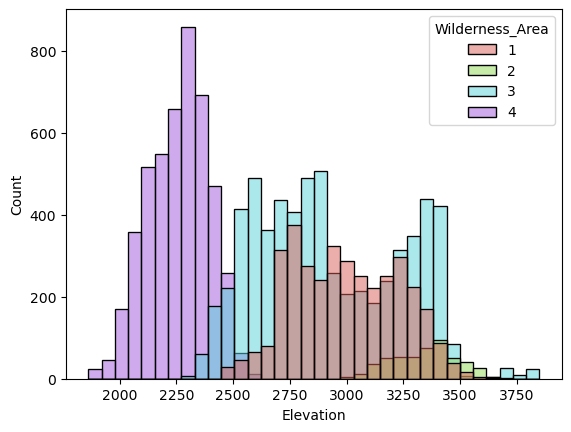

In [35]:
sns.histplot(train_df,x="Elevation", hue="Wilderness_Area",palette= sns.color_palette("hls", 4))

<Axes: xlabel='Slope', ylabel='Count'>

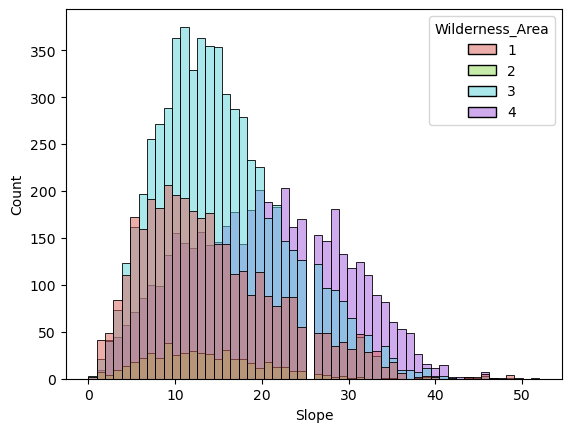

In [36]:
sns.histplot(train_df,x="Slope", hue="Wilderness_Area",palette= sns.color_palette("hls", 4))

<Axes: xlabel='Horizontal_Distance_To_Hydrology', ylabel='Count'>

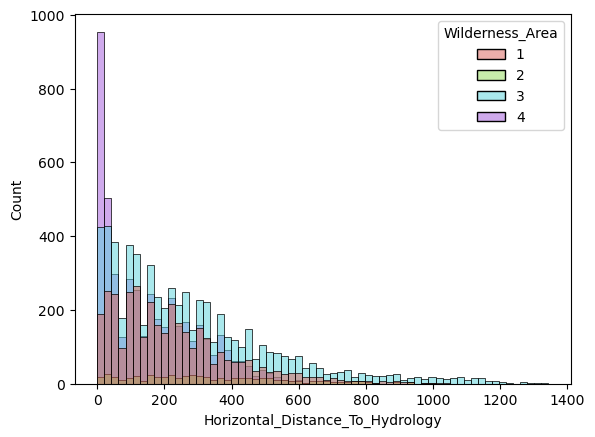

In [37]:
sns.histplot(train_df,x="Horizontal_Distance_To_Hydrology", hue="Wilderness_Area",palette= sns.color_palette("hls", 4))

<Axes: xlabel='Vertical_Distance_To_Hydrology', ylabel='Count'>

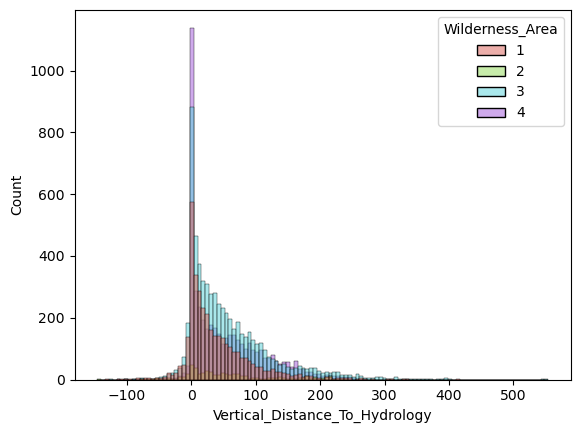

In [38]:
sns.histplot(train_df,x="Vertical_Distance_To_Hydrology", hue="Wilderness_Area",palette= sns.color_palette("hls", 4))

In [39]:
def create_means_function(df):
    means_by_area = df.groupby("Wilderness_Area", as_index=False)[real_value_columns].mean().add_prefix("Mean_")
    return df.merge(right=means_by_area, how="left", left_on="Wilderness_Area", right_on="Mean_Wilderness_Area")

In [40]:
train_df = create_means_function(train_df)
test_df = create_means_function(test_df)
combine = [train_df, test_df]

In [41]:
train_df.shape, test_df.shape

((15120, 69), (565892, 68))

We can also create means by soil type and wilderness area, that might result in a better de-averaged result
Let's try

In [42]:
def create_means_by_soil_type_and_winderness_area(df):
    means_by_sw = df.groupby(["Soil_Type","Wilderness_Area"], as_index=False)[real_value_columns].mean().add_prefix("Mean_SW_")
    return df.merge(right=means_by_sw, how="left", left_on=["Soil_Type","Wilderness_Area"], right_on=["Mean_SW_Soil_Type","Mean_SW_Wilderness_Area"])

In [43]:
train_df = create_means_by_soil_type_and_winderness_area(train_df)
test_df = create_means_by_soil_type_and_winderness_area(test_df)
combine = [train_df, test_df]

In [44]:
train_df.shape, test_df.shape

((15120, 81), (565892, 80))

And we should drop aux columns from the merge

In [45]:
train_df = train_df.drop(["Mean_Wilderness_Area","Mean_SW_Wilderness_Area","Mean_SW_Soil_Type"],axis=1)
test_df = test_df.drop(["Mean_Wilderness_Area","Mean_SW_Wilderness_Area","Mean_SW_Soil_Type"],axis=1)
combine = [train_df, test_df]

In [46]:
train_df.shape, test_df.shape

((15120, 78), (565892, 77))

<Axes: >

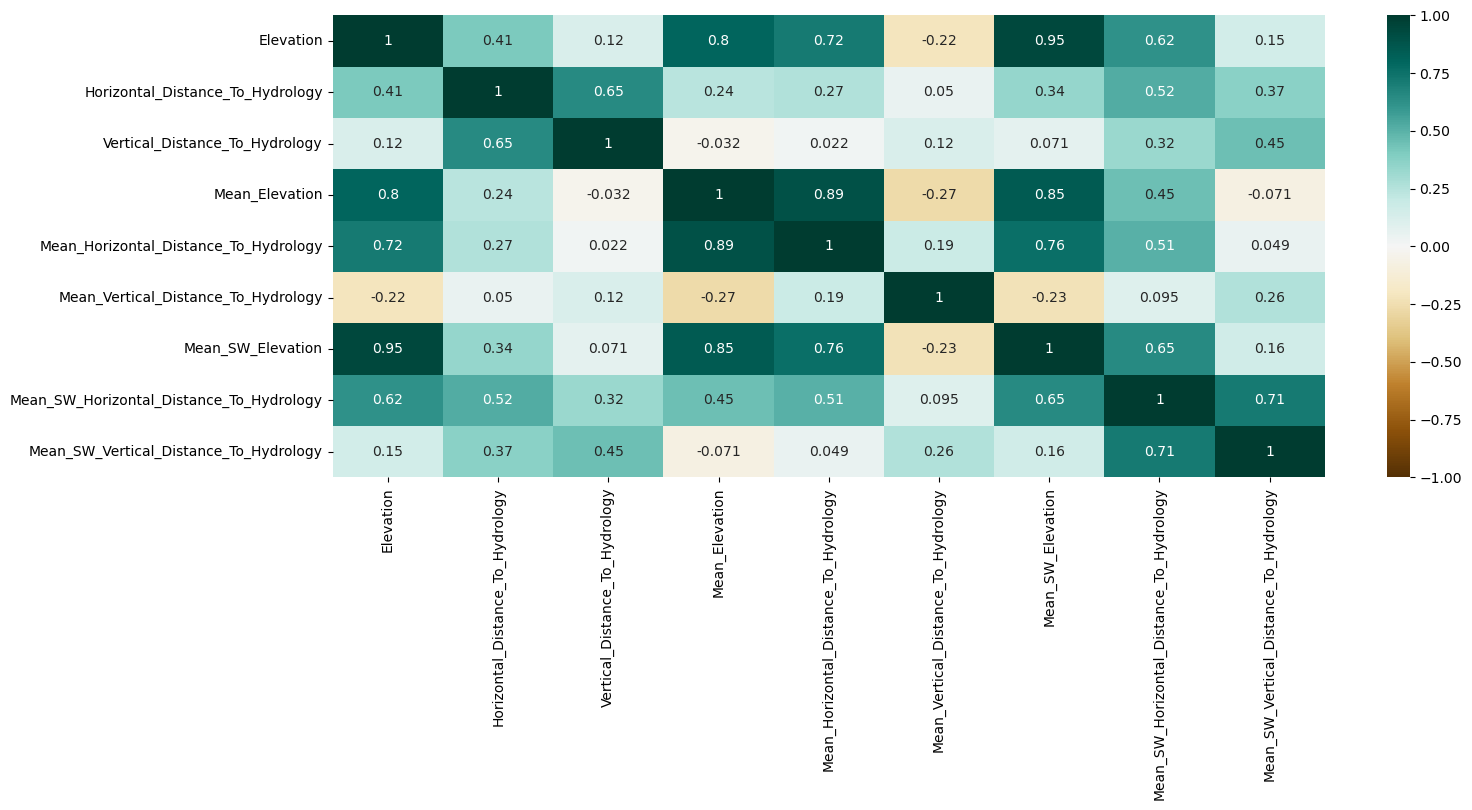

In [47]:
plt.figure(figsize=(16,6))
sns.heatmap(
    train_df.loc[:,train_df.columns.str.endswith("Elevation") | train_df.columns.str.endswith("Hydrology")].corr(),
    vmin=-1.0,
    vmax=1.0,
    annot=True,
    cmap='BrBG',
)

<Axes: >

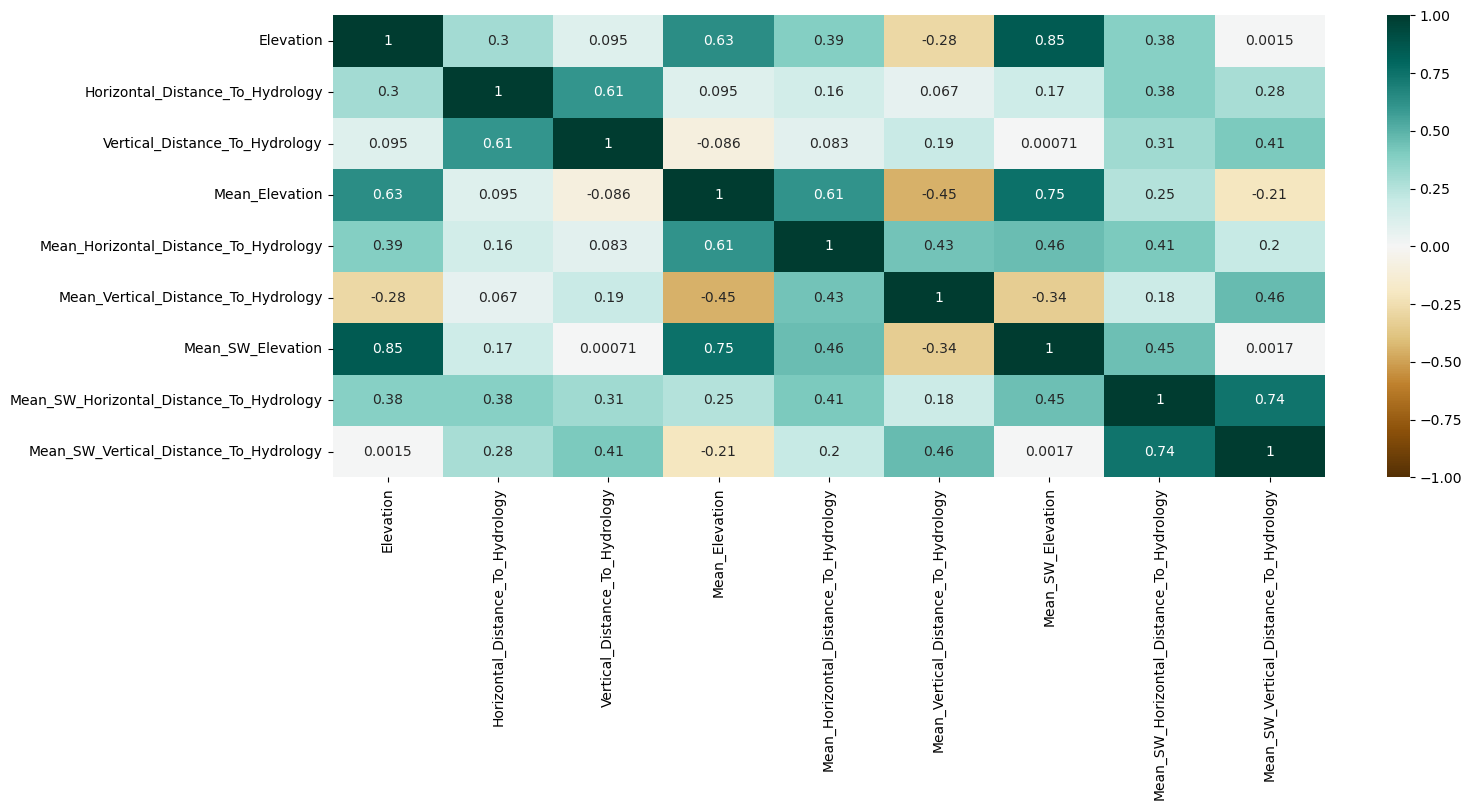

In [48]:
plt.figure(figsize=(16,6))
sns.heatmap(
    test_df.loc[:,test_df.columns.str.endswith("Elevation") | test_df.columns.str.endswith("Hydrology")].corr(),
    vmin=-1.0,
    vmax=1.0,
    annot=True,
    cmap='BrBG',
)

### Conclusions
- Adding calculated features based on the first one added strongly correlated variables to the model
- While this can be interesting for tree-based models, this can be a nightmare for linear models

## Let's predict! 
This is a multiclass classification problem that can be made linear or not according to the features we use.
Let's start with a non-linear method based on trees, without using the dummy variables in order to prevent data sparsity

In [49]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [50]:
from sklearn.model_selection import train_test_split

In [51]:
from sklearn.metrics import accuracy_score

In [52]:
# real_value_columns.remove('Hillshade_3pm')
# real_value_columns

In [53]:
tree_cols = real_value_columns + ["Wilderness_Area","Soil_Type"] +  ["Mean_" + c for c in real_value_columns] + ["Mean_SW_" + c for c in real_value_columns]

X_train, X_test, y_train, y_test = train_test_split(train_df[tree_cols], train_df["Cover_Type"], test_size=0.3)

In [54]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10584, 32), (4536, 32), (10584,), (4536,))

In [55]:
def get_score_and_predictions(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    return score, y_pred

In [56]:
models = [
    RandomForestClassifier(n_estimators=100, n_jobs=3),
    DecisionTreeClassifier(),
]
scores = []
predictions = []

In [57]:
for i in range(0, len(models)):
    score, prediction = get_score_and_predictions(models[i], X_train, X_test, y_train, y_test)
    scores.append(score)
    predictions.append(prediction)

In [58]:
scores

[0.847663139329806, 0.7894620811287478]

In [59]:
predictions

[array([5, 3, 3, ..., 1, 6, 1], dtype=int64),
 array([5, 3, 3, ..., 2, 3, 1], dtype=int64)]

### Conclusions
- Random Forest Classifier still performs poorly and is unstable, probably would benefit from Cross Validation techniques
- Elevation, Distance from Roadways and Fire points, Mean_SW_Elevation, Soil_Type and Distance to hidrology seem the mos important variables (yet to see)

In [60]:
pd.Series(models[0].feature_importances_, index=X_train.columns).sort_values(ascending=False)

Elevation                                     0.168740
Horizontal_Distance_To_Roadways               0.072179
Horizontal_Distance_To_Fire_Points            0.064489
Mean_SW_Elevation                             0.063157
Horizontal_Distance_To_Hydrology              0.057053
Soil_Type                                     0.055239
Vertical_Distance_To_Hydrology                0.048978
Aspect                                        0.045900
Hillshade_9am                                 0.045416
Hillshade_3pm                                 0.042503
Hillshade_Noon                                0.039195
Slope                                         0.032836
Mean_SW_Horizontal_Distance_To_Fire_Points    0.031584
Mean_SW_Horizontal_Distance_To_Hydrology      0.029085
Mean_SW_Horizontal_Distance_To_Roadways       0.028650
Mean_SW_Hillshade_9am                         0.016522
Mean_SW_Hillshade_Noon                        0.015065
Mean_SW_Slope                                 0.015052
Mean_SW_Ve

### Cross validation
- In order to properly test models, we are introducing Cross Validation

In [61]:
from sklearn.model_selection import StratifiedKFold

In [62]:
number_of_splits = 10

In [63]:
stratKF= StratifiedKFold(n_splits=number_of_splits)

In [64]:
X = train_df.drop("Cover_Type", axis=1)
y = train_df.loc[:,"Cover_Type"]

scores = [] # 2-D list to store all scores for each fold and model
predictions = [] # 2-D list to store all predictions for each fold and model

for fold_index, (train_index, test_index) in enumerate(stratKF.split(X, y)):
    print("Fold: ", fold_index, "\tTrain: ", train_index, "\tTest: ", test_index)
    # print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    X_train, X_test = X.loc[train_index,:], X.loc[test_index,:]
    y_train, y_test = train_df.loc[train_index,"Cover_Type"], train_df.loc[test_index,"Cover_Type"]
    
    fold_scores = [] # used to store all models scores for the specific fold being tested right now
    fold_predictions = [] # used to store all models predictions for the specific fold being tested right now
    
    for model_index in range(0,len(models)):
        score, prediction = get_score_and_predictions(models[model_index], X_train[tree_cols], X_test[tree_cols], y_train, y_test)
        fold_scores.append(score)
        fold_predictions.append(prediction)
    
    scores.append(fold_scores)
    predictions.append(fold_predictions)    

Fold:  0 	Train:  [  373   374   375 ... 15117 15118 15119] 	Test:  [   0    1    2 ... 5656 5657 5658]
Fold:  1 	Train:  [    0     1     2 ... 15117 15118 15119] 	Test:  [ 373  374  375 ... 7459 7460 7475]
Fold:  2 	Train:  [    0     1     2 ... 15117 15118 15119] 	Test:  [ 727  728  730 ... 8082 8092 8093]
Fold:  3 	Train:  [    0     1     2 ... 15117 15118 15119] 	Test:  [1111 1112 1113 ... 9174 9175 9182]
Fold:  4 	Train:  [    0     1     2 ... 15117 15118 15119] 	Test:  [2527 2537 2547 ... 9487 9488 9492]
Fold:  5 	Train:  [    0     1     2 ... 15117 15118 15119] 	Test:  [ 4635  4636  4640 ... 10799 10800 10802]
Fold:  6 	Train:  [    0     1     2 ... 15117 15118 15119] 	Test:  [ 5114  5116  5126 ... 11183 11184 11185]
Fold:  7 	Train:  [    0     1     2 ... 15117 15118 15119] 	Test:  [ 5851  5852  5854 ... 13730 13735 13739]
Fold:  8 	Train:  [    0     1     2 ... 15117 15118 15119] 	Test:  [11517 11518 11519 ... 14427 14429 14430]
Fold:  9 	Train:  [    0     1     2 ...

In [65]:
# converts dimension to: model number, fold number -> model score on that fold
scores = np.transpose(scores)

In [66]:
scores

array([[0.69246032, 0.79232804, 0.78108466, 0.71693122, 0.76917989,
        0.76124339, 0.78108466, 0.79960317, 0.8531746 , 0.83201058],
       [0.66534392, 0.72883598, 0.72089947, 0.68187831, 0.68386243,
        0.69179894, 0.68783069, 0.72685185, 0.79034392, 0.78240741]])

In [67]:
# converts dimension to: model number, fold number, instance prediction number -> predicted class for the particular instance for that model in that fold
predictions = np.array(predictions).transpose(1,0,2)

In [68]:
# and models average score ....
[fold_scores.mean() for fold_scores in scores]

[0.7779100529100529, 0.716005291005291]

## Let's test some other models with our previous ones

### Linear models
- Logistic Regression
- Naive Bayes (GaussianNB)
- SVM (with linear Kernel)

### Non-linear models
- k Nearest Neighbors
- Decision Trees
- Random Forests
- Gradient Boosting
- SVM (with non linear kenel)

### Transformations

In order to do that we will need to create some handler funcitons to transform data according to the model we are willing to choose. This needs to happen because different models benefit from different types of treatment of data. Transformations that can be applied to the data:
- Scaling variables
- One hot encoding (or at least selecting the one-hot version of the `Wilderness_Area` and `Soil_Type` variables
- Dimensionality reduction
- Feature selection

### Transformations by model

For each model, the following transformations will be applied

- Logistic Regression

    - Drop non-linear variables such as `Wilderness_Area` and `Soil_Type`
    - Include one-hot encoding variables created from `Wilderness_Area` and `Soil_Type`
    - Drop the last column from `Wilderness_Area` and `Soil_Type` one-hot encoded variables as it is redundant and add no information (can be infered from others)
    - Include and scale real value variables such as Elevation, Slope, etc
    - Decide on whether or not remove correlated variables
    - Log transform real value variables in order to reduce skeweness
    - Recaulculate `Mean_SW` variables from the scaled variables as they appear to be more relevant

- Naive Bayes

    - Assumes independence between features of the model, therefore removing correlated variables might be interesting
    - It also handles well sparse data and can be considered linear, so One-hot encoding variables should be included (removing the last one for independence)
    - As it is not based on distance, but rather on probabilities, features does not need to be scaled nor follow any particular distribution

- kNN, SVM

    - They are both distance-based algorithms that require feature scaling (preferably minmaxscaler - normalization)
    - One hot encoded variables should be included
    -
    
- Decision Trees, Random Forests and Gradient Boosting

    - We don't really want to include one-hot encoding variables as it adds sparsity to data and tree-based methods perform worse in sparse conditions
    - Include categoriacal variables `Wilderness_Area` and `Soil_Type`
    - Include real value variables withoud scaling such as Elevation, Slope, etc
    - Include `Mean_SW` variables without the need for scaled variables


### Importing libraries

In [69]:
# Preprocessing toools
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.pipeline import Pipeline

# Non-linear models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Linear models
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier

### Defining handler functions

In [70]:
def drop_id(df):
    return df.drop(["Id"], axis=1)

In [71]:
def drop_categorical_variables(df):
    return df.drop(["Wilderness_Area","Soil_Type"], axis=1)

In [72]:
def drop_one_hot_variables(df):
    mask = ((df.columns.str.startswith("Wilderness_Area")) | (df.columns.str.startswith("Soil_Type"))) \
          & ((df.columns != "Wilderness_Area") & (df.columns != "Soil_Type"))
    return df.drop(df.columns[mask], axis=1)

In [73]:
def drop_mean_by_area_variables(df):
    mask = (df.columns.str.startswith("Mean_")) & (~df.columns.str.startswith("Mean_SW"))
    return df.drop(df.columns[mask], axis=1)

In [74]:
def drop_mean_by_soil_type_and_area_variables(df):
    mask = df.columns.str.startswith("Mean_SW")
    return df.drop(df.columns[mask], axis=1)

In [75]:
def drop_hillshade_3pm_variables(df):
    mask = df.columns.str.endswith("Hillshade_3pm")
    return df.drop(df.columns[mask], axis=1)

In [76]:
def drop_one_column_of_one_hot_variables(df):
    mask = (df.columns == 'Soil_Type1') | (df.columns == 'Wilderness_Area1') 
    return df.drop(df.columns[mask], axis=1)

In [77]:
def recalculate_mean_by_soil_and_area(df, features):
    means_by_sw = df.groupby(["Soil_Type","Wilderness_Area"], as_index=False)[features].mean().add_prefix("Mean_SW_")
    mask = df.columns.str.startswith("Mean_SW_")
    return (
        df
        .drop(df.columns[mask], axis=1)
        .merge(right=means_by_sw, how="left", left_on=["Soil_Type","Wilderness_Area"], right_on=["Mean_SW_Soil_Type","Mean_SW_Wilderness_Area"])
        .drop(["Mean_SW_Wilderness_Area","Mean_SW_Soil_Type"],axis=1)
    )

In [78]:
def get_scaler_for_featutres(df, features):
    scaler = MinMaxScaler()
    scaler.fit(df[features])
    return df, scaler

In [79]:
def scale_features(df, features, scaler):
    mask = df.columns.isin(features)
    transformed_df = pd.DataFrame(scaler.transform(df[df.columns[mask]]),columns=df[df.columns[mask]].columns)
    not_transformed_df = df[df.columns[~mask]]
    transformed_df.index = df.index
    return pd.concat([transformed_df, not_transformed_df], join="inner", axis=1)
    return transformed_df, not_transformed_df

In [80]:
def log_transform(df, features):
    mask = df.columns.isin(features)
    transformed_df = np.log(df[features] + 1)
    not_transformed_df = df[df.columns[~mask]]
    transformed_df.index = df.index
    return pd.concat([transformed_df, not_transformed_df], join="inner", axis=1)

In [81]:
# drop_id_transformer = FunctionTransformer(drop_id)
# drop_categorical_variables_transformer = FunctionTransformer(drop_categorical_variables)
# drop_one_hot_variables_transformer = FunctionTransformer(drop_one_hot_variables)
# drop_mean_by_area_variables_transformer = FunctionTransformer(drop_mean_by_area_variables)
# drop_mean_by_soil_type_and_area_variables_transformer = FunctionTransformer(drop_mean_by_soil_type_and_area_variables)
# drop_one_column_of_one_hot_variables_transformer = FunctionTransformer(drop_one_column_of_one_hot_variables)
# recalculate_mean_by_soil_and_area_transformer = FunctionTransformer(recalculate_mean_by_soil_and_area)
# get_scaler_for_featutres_transformer = FunctionTransformer(get_scaler_for_featutres)
# _transformer = FunctionTransformer()
# _transformer = FunctionTransformer()
# _transformer = FunctionTransformer()

### Defining models and transformations to be applied

In [82]:
def ensemble_transform_pipe(df, features_to_scale=None, scaler=None):
    return (
        df
        .pipe(drop_id)
        .pipe(drop_one_hot_variables)
        .pipe(drop_mean_by_area_variables)
        .pipe(drop_hillshade_3pm_variables)
    ), None

In [83]:
def distance_based_transform_pipe(df, features_to_scale=None, scaler=None):
    df2 = (
        df
        .pipe(drop_id)
        .pipe(drop_mean_by_area_variables)
        .pipe(drop_mean_by_soil_type_and_area_variables)
        .pipe(drop_hillshade_3pm_variables)
        .pipe(drop_one_column_of_one_hot_variables)
    )
    
    # If no feature_to_scale is passed, returns df2 as is
    if features_to_scale == None:
        return df2
    
    # If no scaler is passed, then it creates a new scaler. Usually X_train creates a scaler which is reused on X_test
    if scaler == None:
        df2, scaler = get_scaler_for_featutres(df2, features_to_scale)    
    
    return (
        df2
        # .pipe(scale_features, features_to_scale, scaler)
        .pipe(recalculate_mean_by_soil_and_area, features_to_scale)
        .pipe(drop_categorical_variables)
    ), scaler

In [84]:
def linear_model_transform_pipe(df, features_to_scale=None, scaler=None):
    df2 = (
        df
        .pipe(drop_id)
        .pipe(drop_mean_by_area_variables)
        .pipe(drop_mean_by_soil_type_and_area_variables)
        .pipe(drop_hillshade_3pm_variables)
        .pipe(drop_one_column_of_one_hot_variables)
    )
    
    # If no feature_to_scale is passed, returns df2 as is
    if features_to_scale == None:
        return df2
    
    # If no scaler is passed, then it creates a new scaler. Usually X_train creates a scaler which is reused on X_test
    if scaler == None:
        df2, scaler = get_scaler_for_featutres(df2, features_to_scale)    
    
    return (
        df2
        .pipe(scale_features, features_to_scale, scaler)
        # .pipe(log_transform,features_to_scale)
        .pipe(recalculate_mean_by_soil_and_area, features_to_scale)
        .pipe(drop_categorical_variables)
    ), scaler

### Aplying transformations and running models

In [85]:
from sklearn.model_selection import cross_val_score

In [86]:
def get_score_and_predictions(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    return score, y_pred

In [87]:
X = train_df.drop(["Cover_Type"], axis=1)
target = train_df["Cover_Type"]

In [88]:
real_value_columns.remove('Hillshade_3pm')
real_value_columns

['Elevation',
 'Aspect',
 'Slope',
 'Horizontal_Distance_To_Hydrology',
 'Vertical_Distance_To_Hydrology',
 'Horizontal_Distance_To_Roadways',
 'Hillshade_9am',
 'Hillshade_Noon',
 'Horizontal_Distance_To_Fire_Points']

In [89]:
# List of 4 elements tuple: model_name, sklearn model, transformation pipeline, features to be scaled
models_and_transformations = [
    ('Logistic Regression Classifier', LogisticRegression(n_jobs=3), linear_model_transform_pipe, real_value_columns),
    ('Naive Bayes (Gauss) Classifier', GaussianNB(), linear_model_transform_pipe, real_value_columns),
    # ('Linear SVM Classifier', SVC(kernel='linear'), distance_based_transform_pipe, real_value_columns),
    ('K Nearest Neighbors Classifier', KNeighborsClassifier(n_neighbors=3, n_jobs=3), distance_based_transform_pipe, real_value_columns),
    ('Decision Tree Classifier', DecisionTreeClassifier(), ensemble_transform_pipe, None),
    ('RandomForest Classifier', RandomForestClassifier(n_estimators=100, n_jobs=3), ensemble_transform_pipe, None),
    ('Gradient Boosting Classifier', GradientBoostingClassifier(n_estimators=100), ensemble_transform_pipe, None),
]

In [90]:
print("Starting evaluation of models ...\n")
scores =[]
for model_index in range(0,len(models_and_transformations)):
    model_name, model, transform_func, features_to_scale = models_and_transformations[model_index]
    transformed_X, scaler = transform_func(X,features_to_scale,None)
    model_scores = cross_val_score(model, transformed_X, target, scoring='accuracy', cv=10, n_jobs=3)
    scores.append(model_scores)
    print(model_name, "\tAvg. Score: ", "%.3f" % model_scores.mean())

Starting evaluation of models ...

Logistic Regression Classifier 	Avg. Score:  0.640
Naive Bayes (Gauss) Classifier 	Avg. Score:  0.459
K Nearest Neighbors Classifier 	Avg. Score:  0.740
Decision Tree Classifier 	Avg. Score:  0.717
RandomForest Classifier 	Avg. Score:  0.786
Gradient Boosting Classifier 	Avg. Score:  0.722


In [91]:
# skfold = StratifiedKFold(n_splits = 2)
# scores = []
# predictions = []

In [92]:
# for fold_index, (train_index, test_index) in enumerate(skfold.split(X, target)):
#     print("Fold: ",fold_index,"\t Train: ", train_index, "\tTest: ", test_index)
#     X_train, X_test = X.loc[train_index,:], X.loc[test_index,:]
#     y_train, y_test = target.loc[train_index], target.loc[test_index]
    
#     fold_scores = [] # used to store all models scores for the specific fold being tested right now
#     fold_predictions = [] # used to store all models predictions for the specific fold being tested right now
    
#     for model_index in range(0,len(models_and_transformations)):
#         model_name, model, transform_func, features_to_scale = models_and_transformations[model_index]
#         transformed_X_train, scaler = transform_func(X_train, features_to_scale, None)
#         transformed_X_test, scaler = transform_func(X_test, features_to_scale, scaler)
#         score, prediction = get_score_and_predictions(model, transformed_X_train, transformed_X_test, y_train, y_test)
#         fold_scores.append(score)
#         fold_predictions.append(prediction)
    
#     scores.append(fold_scores)
#     predictions.append(fold_predictions)    

In [93]:
# # converts dimension to: model number, fold number -> model score on that fold
# scores = np.transpose(scores)

In [94]:
# scores

In [95]:
# # converts dimension to: model number, fold number, instance prediction number -> predicted class for the particular instance for that model in that fold
# predictions = np.array(predictions).transpose(1,0,2)

In [96]:
# and models average score ....
models_performance = []
for idx, (model_scores) in enumerate(scores):
    model_name, _ , __, ___ = models_and_transformations[idx]
    models_performance.append((model_name, model_scores.mean()))

pd.DataFrame(models_performance,columns=["Model","Avg_Accuracy"]).sort_values(by="Avg_Accuracy", ascending=False)

,Model,Avg_Accuracy
4,RandomForest Classifier,0.786376
2,K Nearest Neighbors Classifier,0.740146
5,Gradient Boosting Classifier,0.722487
3,Decision Tree Classifier,0.717063
0,Logistic Regression Classifier,0.640013
1,Naive Bayes (Gauss) Classifier,0.458664


### Conclusions

Overall, RandomForest models seems to perform better given the 10 predicting exercises applied with Stratified K-fold Cross Validation. KNN model appears to also be working well. 

There are two possible paths from here
1. Search for optimal RandomForest / kNN hyperparameters and therefore tune our selected models
2. Try some robust techniques to remove and add new features in order to see how robust are the models

### 1. Defining search space for hyperparameters from both models

In [97]:
# kNN
models_and_transformations[2][1].get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': 3,
 'n_neighbors': 3,
 'p': 2,
 'weights': 'uniform'}

In [98]:
# Random Forests
models_and_transformations[4][1].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 3,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [99]:
import sklearn

In [100]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

In [101]:
params_knn = {
    'n_neighbors': np.arange(3,11),
    'leaf_size': np.arange(10,50,1),
    'p': np.arange(1,3,1),
}

In [102]:
base_knn = KNeighborsClassifier(n_jobs=3)

In [103]:
search = HalvingRandomSearchCV(base_knn, params_knn, scoring='accuracy', cv=5, n_jobs=3)

In [104]:
X_knn, scaler_knn = distance_based_transform_pipe(X, real_value_columns,None)
search.fit(X_knn, target)

HalvingRandomSearchCV(estimator=KNeighborsClassifier(n_jobs=3), n_jobs=3,
                      param_distributions={'leaf_size': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49]),
                                           'n_neighbors': array([ 3,  4,  5,  6,  7,  8,  9, 10]),
                                           'p': array([1, 2])},
                      scoring='accuracy')

In [105]:
search.best_score_

0.6857142857142857

In [106]:
search.best_params_

{'p': 1, 'n_neighbors': 3, 'leaf_size': 14}

In [107]:
from sklearn.model_selection import RandomizedSearchCV

In [108]:
search = RandomizedSearchCV(base_knn, params_knn, scoring='accuracy', cv=10, n_jobs=3)

In [109]:
search.fit(X_knn, target)

RandomizedSearchCV(cv=10, estimator=KNeighborsClassifier(n_jobs=3), n_jobs=3,
                   param_distributions={'leaf_size': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49]),
                                        'n_neighbors': array([ 3,  4,  5,  6,  7,  8,  9, 10]),
                                        'p': array([1, 2])},
                   scoring='accuracy')

In [110]:
search.best_score_, search.best_params_, search.n_iter

(0.7511243386243386, {'p': 1, 'n_neighbors': 3, 'leaf_size': 19}, 10)

In [111]:
# from sklearn.model_selection import GridSearchCV

In [112]:
# search = GridSearchCV(base_knn, params_knn, scoring='accuracy', cv=5, n_jobs=3)

In [113]:
# search.fit(X_knn, target)

In [114]:
# search.best_score_, search.best_params_

In [115]:
random_forest_params = {
    'max_depth': np.arange(3,30),
    'min_samples_split': np.arange(2,1000,10),
    'max_leaf_nodes': np.arange(7,500,10),
    'n_estimators': np.arange(10, 310, 10),
    'max_samples': np.arange(0.05, 0.55, 0.05),
}

In [116]:
base_random_forest = RandomForestClassifier(n_jobs=3)

In [118]:
search_rf = HalvingRandomSearchCV(
    base_random_forest, 
    random_forest_params, 
    scoring='accuracy', 
    cv=5, 
    n_jobs=3
)

In [119]:
X_rf, scaler_rf = ensemble_transform_pipe(X, None, None)

In [120]:
search_rf.fit(X_rf, target)

HalvingRandomSearchCV(estimator=RandomForestClassifier(n_jobs=3), n_jobs=3,
                      param_distributions={'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                                           'max_leaf_nodes': array([  7,  17,  27,  37,  47,  57,  67,  77,  87,  97, 107, 117, 127,
       137, 147, 157, 167, 177, 187, 197, 207, 217, 227, 237, 247, 257,
       267, 277, 287, 297, 307, 317, 327, 337, 347, 357, 367...
       392, 402, 412, 422, 432, 442, 452, 462, 472, 482, 492, 502, 512,
       522, 532, 542, 552, 562, 572, 582, 592, 602, 612, 622, 632, 642,
       652, 662, 672, 682, 692, 702, 712, 722, 732, 742, 752, 762, 772,
       782, 792, 802, 812, 822, 832, 842, 852, 862, 872, 882, 892, 902,
       912, 922, 932, 942, 952, 962, 972, 982, 992]),
                                           'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260,
       270, 280, 290, 300])},
                      scoring='accuracy')

In [124]:
print(search_rf.best_score_)
search_rf.best_params_

0.7088183421516755


{'n_estimators': 240,
 'min_samples_split': 12,
 'max_samples': 0.5,
 'max_leaf_nodes': 197,
 'max_depth': 17}

In [133]:
best_rf_model = models_and_transformations[4][1]

In [134]:
best_rf_model.fit(X_rf, target)

RandomForestClassifier(n_jobs=3)

In [135]:
X_test_transformed = ensemble_transform_pipe(test_df, scaler_rf, None)[0]

In [136]:
predictions = best_rf_model.predict(X_test_transformed)

In [137]:
X_test_transformed.shape, predictions.shape

((565892, 20), (565892,))

In [140]:
df_submission = pd.DataFrame(predictions,columns=["Cover_Type"])
df_submission["Id"] = test_df["Id"]
df_submission

,Cover_Type,Id
0,2,15121
1,1,15122
2,1,15123
3,2,15124
4,2,15125
...,...,...
565887,3,581008
565888,3,581009
565889,3,581010
565890,6,581011


In [142]:
df_submission[["Id","Cover_Type"]].to_csv('./outputs/submission.csv', index=False)

In [143]:
!head -5 ./outputs/submission.csv

Id,Cover_Type
15121,2
15122,1
15123,1
15124,2


In [145]:
!wc -l < ./outputs/submission.csv

565893
